# PlotBot



### Imports

In [1]:
# Core
from datetime import date, timedelta, datetime, timezone
from operator import itemgetter
import json
import re

# Logging
import sys
import logging
logging.basicConfig(
    format='%(asctime)s | %(levelname)s : %(message)s',
    stream=sys.stdout) # Needed in Jupyter. Comment out if only need to see in log file.

# Scheduler
import schedule
from time import sleep

# Numpy, Pandas and PyPlot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style(
    'darkgrid', 
    {
        'axes.facecolor': '0.9',
        'axes.titlesize': 'x-large',
        'figure.titlesize': 'x-large',
    }
)

# API
import tweepy
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Own
from twitter_config import *

### Constants and Globals

In [2]:
SLEEP_SEC = 60 * 5
PAGE_SIZE = 2
PAGES = 1
TODAY = date.today().strftime('%m/%d/%y')

_AUTH = tweepy.OAuthHandler(TWITTER_CONSUMER_KEY, TWITTER_CONSUMER_SECRET)
_AUTH.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_TOKEN_SECRET)

TWITTER_API = tweepy.API(_AUTH, parser=tweepy.parsers.JSONParser())
SENTIMENT_ANALYZER = SentimentIntensityAnalyzer()

TWEET_FROM = '@feng443'
TWEET_TO = 'chanfengcom'

DEBUG = True
LOG_FILE = 'PlotBot.log'

### Define PlotBot Class

In [3]:
tweets = TWITTER_API.search(TWEET_FROM, count=PAGE_SIZE)['statuses']

In [4]:
tweet = tweets[0]
tweet['user']['screen_name']

'feng443'

In [5]:
[tweet['user']['screen_name'] for tweet in tweets]

['feng443', 'feng443']

In [6]:
[tweet['text'] for tweet in tweets]

['@feng443 Sentiment Analsyis of Tweets (03/24/18), requested by feng443 https://t.co/47zZaUwazx',
 '@feng443 Sentiment Analsyis of Tweets (03/24/18), requested by feng443 https://t.co/pC0edPjKw4']

In [7]:
class PlotBot(object):
    
    _analyzed = []
    _to_analyze = []
    _df = pd.DataFrame(index=pd.Index(
        list(range(-PAGE_SIZE * PAGES)),
        name='Tweets Ago'))
    
    @property
    def data(self):
        return self._df

    @property
    def logger(self):
        logger = logging.getLogger('PlotBot')
        if self._debug:
            logger.setLevel(logging.DEBUG)
        if self._log_file:
            logger.addHandler(logging.FileHandler(self._log_file))
        return logger
    
    def __init__(self, debug=False, log_file=None,
                ignore_old=True):
        self._re = re.compile('Analyze: @(\w{1,15})')
        self._debug = debug
        self._log_file = log_file
        self._ignore_old = ignore_old
        
    def _scan_tweets(self, debug=True):
        self.logger.info('Scan tweets ...')
        self._tweets = []
        for tweet in TWITTER_API.search(TWEET_FROM, count=PAGE_SIZE)['statuses']:
            targets = self._re.findall(tweet['text'])
            if targets:
                target = targets[0]
                requester = tweet['user']['screen_name']
            else:
                continue
            self.logger.debug(f'{requester} ask for {target}')
            if target not in self._analyzed:
                if self._ignore_old and self._is_old_tweet(tweet):
                    self.logger.debug('is_old_tweet: {}'.format(self._is_old_tweet(tweet)))
                    self.logger.info('Skip older tweets.')
                    break
                self.logger.debug(f'Put into _to_analyze({target}, {requester})')
                self._to_analyze.append((target, requester))    
                #created_at = tweet['created_at']
            else:
                self.logger.info(f'{target} already analyzed. Skip.')
    
    def _is_old_tweet(self, tweet):
        tweet_datetime = datetime.strptime(
            tweet['created_at'], "%a %b %d %H:%M:%S %z %Y")
        self.logger.debug(f'tweet time: {tweet_datetime}')
        now = datetime.now(timezone.utc) 
        self.logger.debug(f'now: {now}')
        return False #(now - tweet_datetime) > timedelta(minutes=SCAN_MINUTES * 2) # Times 2 to allow some processing time buffer
        
    def _analyze_all(self):
        if not self._to_analyze:
            self.logger.info('Nothing new.')
            return

        self.logger.info('Analyze all ...')
        while self._to_analyze:
            (target, requester) = self._to_analyze.pop()
            self._analyzed.append(target)
            self._analyze(target, requester)
            self._plot(target, requester)
            self._tweet_out(target, requester)
    
    def _analyze(self, target, requester):
        self.logger.info(f'Analyze {target}, requested by {requester}')
        tweets_ago = 0
        for page in range(PAGES):
            for tweet in TWITTER_API.user_timeline(target, count=PAGE_SIZE, page=page):
                self._df.at[tweets_ago, 
                        f'@{target}'] = SENTIMENT_ANALYZER.polarity_scores(tweet['text'])['compound']
                tweets_ago -= 1
    
    def _plot(self, target, requester):
        fig, ax = plt.subplots(figsize=(8, 6))
        self.data.plot.line(
            y=f'@{target}',
            marker='o',
            ax=ax,
            alpha=0.8,
        )
        plt.legend(
            title='Tweets',
            bbox_to_anchor=(1.25, 1)
        )
        plt.title(f'Sentiments Analysis of Tweet ({TODAY}), requeted by {requester}',
            fontsize=16)
        plt.ylabel('Tweet Polarity')
        plt.gca().invert_xaxis()
        
        plt.savefig('plot_bot.png', bbox_inches='tight')
        plt.show()
        
    def _tweet_out(self, target, requester):
        self.logger.info(f'Tweet out  ...{target}')
        TWITTER_API.update_with_media('plot_bot.png',
                                      f'@{requester} Sentiment Analsyis of Tweets ({TODAY}), requested by {requester}')
        
    def listen(self):
        self._scan_tweets()
        self._analyze_all()

### Start the Daemon

2018-03-24 22:44:43,573 | INFO : Scan tweets ...
2018-03-24 22:44:43,901 | DEBUG : feng443 ask for CNN
2018-03-24 22:44:43,907 | DEBUG : tweet time: 2018-03-25 01:50:27+00:00
2018-03-24 22:44:43,909 | DEBUG : now: 2018-03-25 02:44:43.908983+00:00
2018-03-24 22:44:43,911 | DEBUG : Put into _to_analyze({target}, {requester})
2018-03-24 22:44:43,914 | DEBUG : chanfengcom ask for CNN
2018-03-24 22:44:43,917 | DEBUG : tweet time: 2018-03-24 21:31:21+00:00
2018-03-24 22:44:43,919 | DEBUG : now: 2018-03-25 02:44:43.919486+00:00
2018-03-24 22:44:43,922 | DEBUG : Put into _to_analyze({target}, {requester})
2018-03-24 22:44:43,927 | INFO : Analyze all ...
2018-03-24 22:44:43,930 | INFO : Analyze CNN, requested by chanfengcom


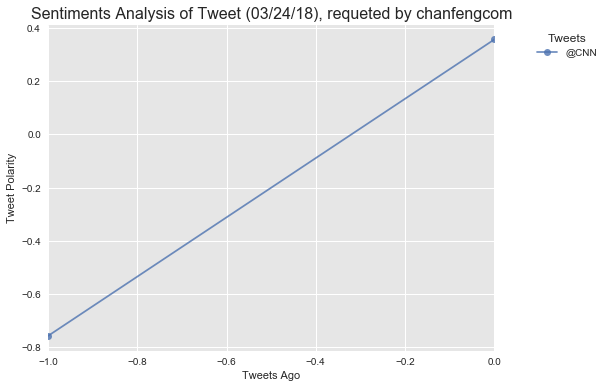

2018-03-24 22:44:44,665 | INFO : Tweet out  ...CNN
2018-03-24 22:44:45,754 | INFO : Analyze CNN, requested by feng443


KeyboardInterrupt: 

In [10]:
schedule.clear()
bot = PlotBot(debug=DEBUG, log_file=LOG_FILE)
schedule.every(60).seconds.do(bot.listen)
    
while True:
    schedule.run_pending()

bot = PlotBot(debug=True, log_file=LOG_FILE, ignore_old=False)
while True:
    bot.listen()
    sleep(SLEEP_SEC)